In [3]:
from os import environ

environ['optimizer'] = 'Adam'
environ['num_workers']= '2'
environ['batch_size']= str(2048)
environ['n_epochs']= '500'
environ['batch_norm']= 'True'
environ['loss_func']='MSE'
environ['layers'] = '300 200 120 80 30'
environ['dropouts'] = '0.3 0.4 0.2 0.1 0.1'
environ['log'] = 'True'
environ['weight_decay'] = '0.01'
environ['cuda_device'] ='cuda:0'
environ['dataset'] = 'data/speedup_dataset2.pkl'

%run utils.ipynb

In [4]:
l = l.load(f"speedup_{optimizer}_batch_norm_{batch_norm}_{loss_func}_nlayers_{len(layers_sizes)}_log_{log}")

In [7]:
l.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


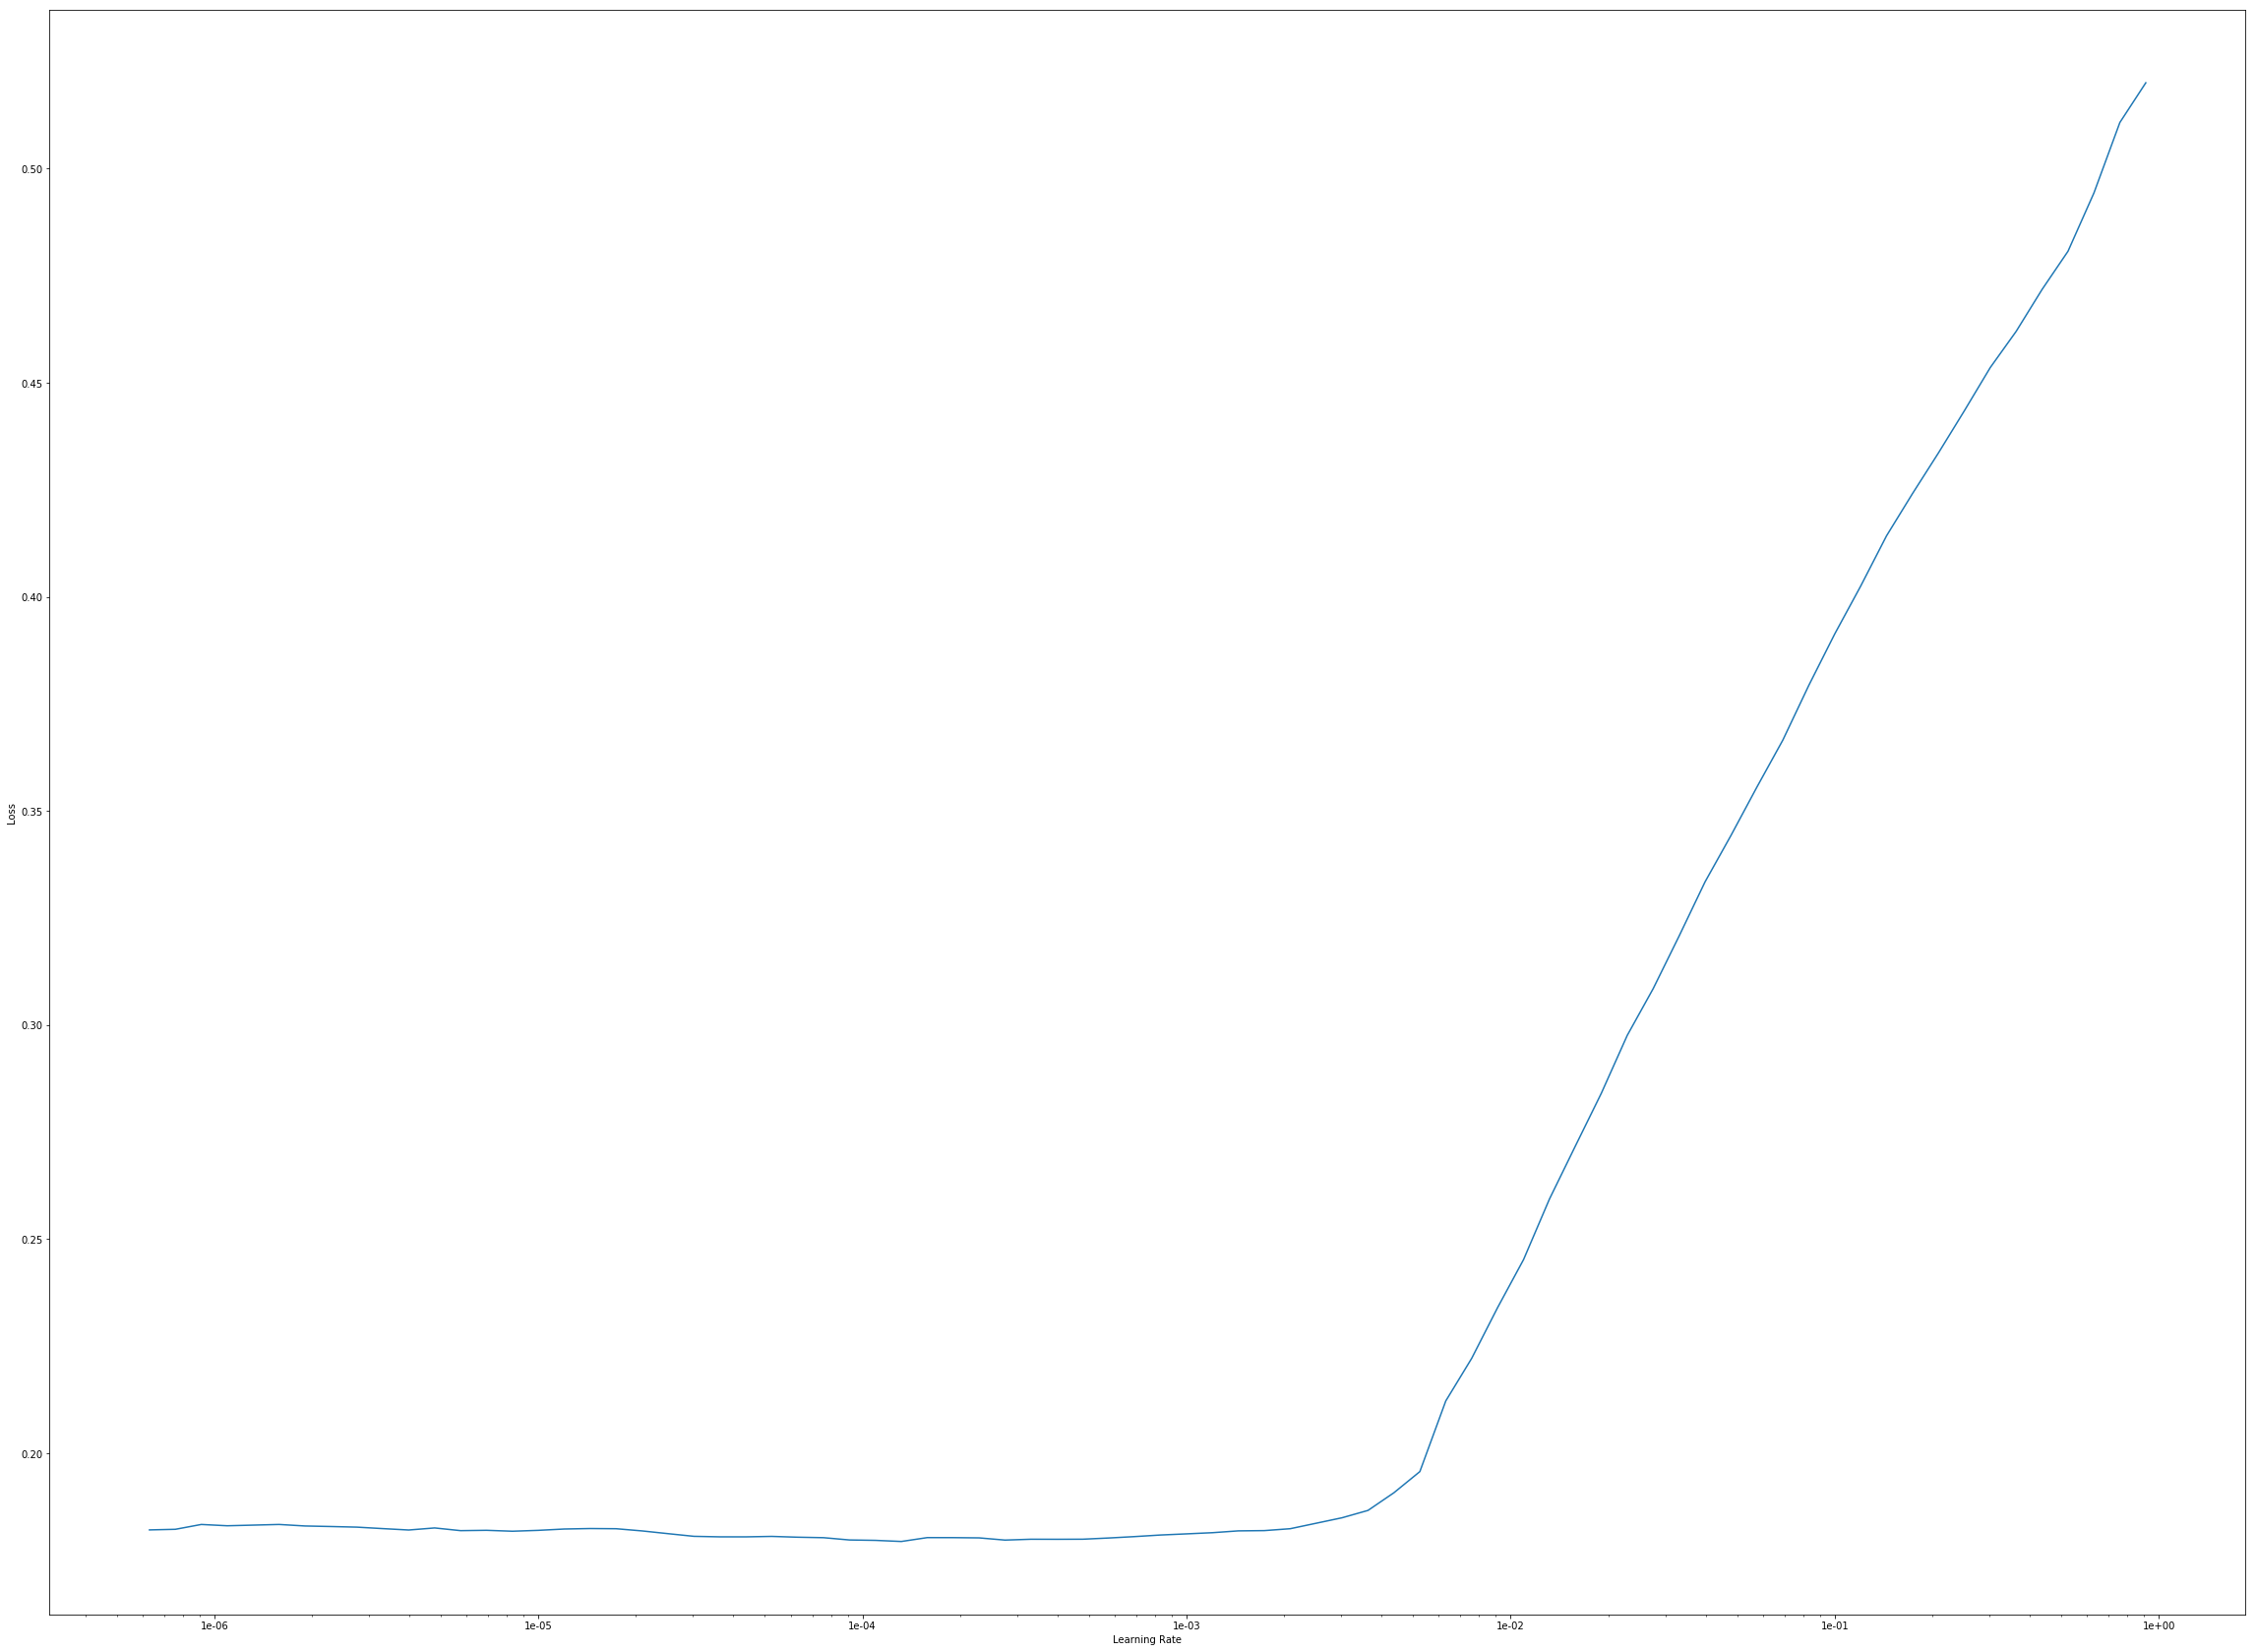

In [8]:
l.recorder.plot()

In [54]:
lr = 1e-05

In [ ]:
l.fit_one_cycle(1000, lr)

epoch,train_loss,valid_loss,mape_criterion,rmse_criterion
1,0.173897,0.156220,15.471283,0.395232
2,0.172765,0.154622,16.156538,0.393163
3,0.171550,0.153247,16.102085,0.391365
4,0.173393,0.153878,15.777186,0.392179
5,0.172368,0.155234,14.788037,0.393941
6,0.172506,0.154118,16.763882,0.392531
7,0.172575,0.152657,16.410528,0.390686
8,0.172635,0.153718,16.435656,0.392004
9,0.172353,0.153789,16.084141,0.392078
10,0.173497,0.154016,16.950935,0.392370


In [ ]:
l.recorder.plot_losses()

In [ ]:
l.save(f"speedup_{optimizer}_batch_norm_{batch_norm}_{loss_func}_nlayers_{len(layers_sizes)}_log_{log}")

In [5]:
val_df = get_results_df(val_dl, l.model, log=log)
train_df = get_results_df(train_dl, l.model, log=log)

In [9]:
df = train_df

In [10]:
df[:][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,185651.000000,185651.000000,1.856510e+05,185651.000000
mean,0.971599,1.184810,3.654603e-01,42.743973
std,1.182745,1.613917,6.470589e-01,55.468258
min,0.015813,0.008491,8.195639e-07,0.000808
25%,0.237138,0.211613,4.606553e-02,12.748050
50%,0.465405,0.565550,1.365227e-01,28.207281
75%,1.312542,1.394052,3.926713e-01,50.755367
max,7.773772,16.089287,1.575080e+01,1743.325073


In [23]:
df[(df.interchange == 0) & (df.tile == 0) & (df.unroll == 1)][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,657.000000,657.000000,657.000000,657.000000
mean,3.948848,5.115778,1.365126,29.287535
std,1.486039,2.790569,1.714994,38.937504
min,0.398863,0.105179,0.003013,0.206864
25%,2.479949,2.706949,0.270402,8.261179
50%,4.648192,5.420588,0.649103,21.397005
75%,4.834735,6.326712,1.784681,33.637047
max,5.690990,12.500638,7.442226,280.300598


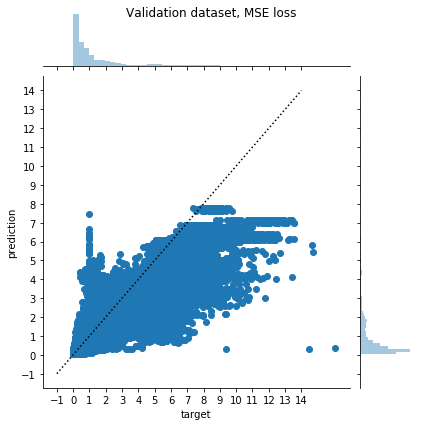

In [11]:
df1 = df[(df.interchange == 0) & (df.tile == 0) & (df.unroll == 1)]
#joint_plot(df1, f"Validation dataset, {loss_func} loss")
df2 = df
joint_plot(df2, f"Validation dataset, {loss_func} loss")